In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader

import os
import cv2
from tqdm.notebook import trange

import gym
from gym import spaces

from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.dqn.policies import CnnPolicy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import sklearn as sk
from sklearn import datasets
# from stable_baselines3.common.policies import register_policy
# register_policy("myPolicy", CnnPolicy)
from glob import glob

In [2]:
os.chdir('/vol1/idrl/idrl_env/mmd/idrl_mmd/')
norm_models = sorted(glob('*norm*.zip'))
models = sorted(glob('*.zip'))
models = [model for model in models if model not in norm_models]

In [3]:
from sklearn.datasets import load_svmlight_file
from dqn import *
import numpy as np
from stable_baselines3 import DQN


train = load_svmlight_file('data/mmd_mnist_torch')
x, y = train
x = x.todense()

sortind = np.argsort(y)
x = x[sortind, :]
y = y[sortind]

test = load_svmlight_file('data/mmd_mnist_torch.t')
testx, testy = test
testx = testx.todense()

In [33]:
width, height = 64, 64
for model_name in models:
    print(model_name)
    model = DQN.load(model_name)
    
    total_rewards = 0
    pred_y_test = []
    count = 0

    for idx in trange(len(testx)):
        # Generate an evaluation observation frame.
        obs = cv2.resize(np.array(testx[idx]).astype(np.float32), (width, height), interpolation = cv2.INTER_CUBIC)
        obs = obs.reshape(width, height, 1)

        # Predict an action based on the observation.
        action, _states = model.predict(obs)
        pred_y_test.append(action)


        # Score the prediction.
        if (action.size > 1):
            # print(action)
            count += 1
            pass
        else:
            reward = 1 if action == testy[idx] else 0
            total_rewards += reward

    print('Accuracy: {:.2f}%'.format(total_rewards / (len(testy) - count) * 100.0))

dqn_cnn_mnist_100_tarun.zip


  0%|          | 0/10000 [00:00<?, ?it/s]

Accuracy: 18.50%
dqn_cnn_mnist_10_tarun.zip


  0%|          | 0/10000 [00:00<?, ?it/s]

Accuracy: 30.57%
dqn_cnn_mnist_1_tarun.zip


  0%|          | 0/10000 [00:00<?, ?it/s]

Accuracy: 70.06%
dqn_cnn_mnist_25_tarun.zip


  0%|          | 0/10000 [00:00<?, ?it/s]

Accuracy: 21.20%
dqn_cnn_mnist_50_tarun.zip


  0%|          | 0/10000 [00:00<?, ?it/s]

Accuracy: 21.78%
dqn_cnn_mnist_5_tarun.zip


  0%|          | 0/10000 [00:00<?, ?it/s]

Accuracy: 49.40%
dqn_cnn_mnist_667_tarun.zip


  0%|          | 0/10000 [00:00<?, ?it/s]

Accuracy: 17.22%
dqn_cnn_mnist_75_tarun.zip


  0%|          | 0/10000 [00:00<?, ?it/s]

Accuracy: 23.31%


In [ ]:
width, height = 64, 64
for model_name in models:
    print(model_name)
    model = DQN.load(model_name)
    
    total_rewards = 0
    pred_y_test = []
    count = 0

    for idx in trange(len(x)):
        # Generate an evaluation observation frame.
        obs = cv2.resize(np.array(x[idx]).astype(np.float32), (width, height), interpolation = cv2.INTER_CUBIC)
        obs = obs.reshape(width, height, 1)

        # Predict an action based on the observation.
        action, _states = model.predict(obs)
        pred_y_test.append(action)


        # Score the prediction.
        if (action.size > 1):
            # print(action)
            count += 1
            pass
        else:
            reward = 1 if action == y[idx] else 0
            total_rewards += reward

    print('Accuracy: {:.2f}%'.format(total_rewards / (len(y) - count) * 100.0))

dqn_cnn_mnist_100_tarun.zip


/vol1/idrl/idrl_env/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


  0%|          | 0/60000 [00:00<?, ?it/s]

In [17]:
protos = sorted(glob('protos/*'))
critics = sorted(glob('critics/*'))
combined = sorted(glob('combined/*'))

epochs = 1

for testm in protos:
    print(testm)
    selected = np.load(testm)
#     print(selected)

    data_indices = random.sample(range(0, 60000), testm)

    env = DummyVecEnv([lambda: USPSGym(width=64, height=64, channels=1, dataset=(x[selected[data_indices], :], y[selected[data_indices]]))])
#     env = DummyVecEnv([lambda: USPSGym(width=64, height=64, channels=1, dataset=(x[selected, :], y[selected]))])

    # Grab the observation shape for generating evaluation frames.
    width, height = env.observation_space.shape[0], env.observation_space.shape[1]

    test_model = DQN(CnnPolicy, env, verbose=1)

    test_model.learn(total_timesteps=len(x) * epochs)
    
    test_model.save('./models/without_norm_{}_{}.zip'.format(testm, epochs))

    accuracy = eval(test_model, testx, testy)

    error = 100 - accuracy
    print("=============== m={} error={} ===============".format(testm, error))
#     break

for testm in critics:
    print(testm)
    selected = np.load(testm)
#     print(selected)
    env = DummyVecEnv([lambda: USPSGym(width=64, height=64, channels=1, dataset=(x[selected, :], y[selected]))])

    # Grab the observation shape for generating evaluation frames.
    width, height = env.observation_space.shape[0], env.observation_space.shape[1]

    test_model = DQN(CnnPolicy, env, verbose=1)

    test_model.learn(total_timesteps=len(x) * epochs)
    
    test_model.save('./models/without_norm_{}_{}.zip'.format(testm, epochs))

    accuracy = eval(test_model, testx, testy)

    error = 100 - accuracy
    print("=============== m={} error={} ===============".format(testm, error))
#     break

for testm in combined:
    print(testm)
    selected = np.load(testm)
#     print(selected)
    env = DummyVecEnv([lambda: USPSGym(width=64, height=64, channels=1, dataset=(x[selected, :], y[selected]))])

    # Grab the observation shape for generating evaluation frames.
    width, height = env.observation_space.shape[0], env.observation_space.shape[1]

    test_model = DQN(CnnPolicy, env, verbose=1)

    test_model.learn(total_timesteps=len(x) * epochs)
    
    test_model.save('./models/without_norm_{}_{}.zip'.format(testm, epochs))

    accuracy = eval(test_model, testx, testy)

    error = 100 - accuracy
    print("=============== m={} error={} ===============".format(testm, error))
#     break

protos/protos_1500.npy
Using cpu device
Wrapping the env in a VecTransposeImage.
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 8710     |
|    time_elapsed     | 0        |
|    total timesteps  | 6000     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.19     |
|    n_updates        | 2500     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 8404     |
|    time_elapsed     | 1        |
|    total timesteps  | 12000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    epis

  0%|          | 0/10000 [00:00<?, ?it/s]

Accuracy: 71.97%
=============== m=protos/protos_1500.npy error=28.02990418026745 ===============
protos/protos_2000.npy
Using cpu device
Wrapping the env in a VecTransposeImage.
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 10456    |
|    time_elapsed     | 0        |
|    total timesteps  | 8000     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.387    |
|    n_updates        | 2500     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 10490    |
|    time_elapsed     | 1        |
|    total timesteps  | 16000    |
----------------------------------
----------------------------------
| rollout/      

  0%|          | 0/10000 [00:00<?, ?it/s]

Accuracy: 74.38%
=============== m=protos/protos_2000.npy error=25.618877067312766 ===============
protos/protos_3000.npy
Using cpu device
Wrapping the env in a VecTransposeImage.
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 9860     |
|    time_elapsed     | 1        |
|    total timesteps  | 12000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.369    |
|    n_updates        | 2500     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 9231     |
|    time_elapsed     | 2        |
|    total timesteps  | 24000    |
----------------------------------
----------------------------------
| rollout/     

  0%|          | 0/10000 [00:00<?, ?it/s]

Accuracy: 75.02%
=============== m=protos/protos_3000.npy error=24.97898276586801 ===============
protos/protos_4500.npy
Using cpu device
Wrapping the env in a VecTransposeImage.
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 9342     |
|    time_elapsed     | 1        |
|    total timesteps  | 18000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.284    |
|    n_updates        | 2500     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 9172     |
|    time_elapsed     | 3        |
|    total timesteps  | 36000    |
----------------------------------
----------------------------------
| rollout/      

  0%|          | 0/10000 [00:00<?, ?it/s]

Accuracy: 72.51%
=============== m=protos/protos_4500.npy error=27.485503426462827 ===============
protos/protos_6000.npy
Using cpu device
Wrapping the env in a VecTransposeImage.
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 9662     |
|    time_elapsed     | 2        |
|    total timesteps  | 24000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.258    |
|    n_updates        | 2500     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 9018     |
|    time_elapsed     | 5        |
|    total timesteps  | 48000    |
----------------------------------


  0%|          | 0/10000 [00:00<?, ?it/s]

Accuracy: 75.25%
=============== m=protos/protos_6000.npy error=24.74923450533207 ===============
critics/crits_1500.npy
Using cpu device
Wrapping the env in a VecTransposeImage.
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 10488    |
|    time_elapsed     | 0        |
|    total timesteps  | 6000     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.25     |
|    n_updates        | 2500     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 9987     |
|    time_elapsed     | 1        |
|    total timesteps  | 12000    |
----------------------------------
----------------------------------
| rollout/      

  0%|          | 0/10000 [00:00<?, ?it/s]

Accuracy: 50.46%
=============== m=critics/crits_1500.npy error=49.54157445463168 ===============
critics/crits_2000.npy
Using cpu device
Wrapping the env in a VecTransposeImage.
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 10470    |
|    time_elapsed     | 0        |
|    total timesteps  | 8000     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.137    |
|    n_updates        | 2500     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 10213    |
|    time_elapsed     | 1        |
|    total timesteps  | 16000    |
----------------------------------
----------------------------------
| rollout/      

  0%|          | 0/10000 [00:00<?, ?it/s]

Accuracy: 55.00%
=============== m=critics/crits_2000.npy error=44.99842221520984 ===============
critics/crits_3000.npy
Using cpu device
Wrapping the env in a VecTransposeImage.
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 10053    |
|    time_elapsed     | 1        |
|    total timesteps  | 12000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.146    |
|    n_updates        | 2500     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 9849     |
|    time_elapsed     | 2        |
|    total timesteps  | 24000    |
----------------------------------
----------------------------------
| rollout/      

  0%|          | 0/10000 [00:00<?, ?it/s]

Accuracy: 58.65%
=============== m=critics/crits_3000.npy error=41.35021097046413 ===============
critics/crits_4500.npy
Using cpu device
Wrapping the env in a VecTransposeImage.
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 9891     |
|    time_elapsed     | 1        |
|    total timesteps  | 18000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.184    |
|    n_updates        | 2500     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 9289     |
|    time_elapsed     | 3        |
|    total timesteps  | 36000    |
----------------------------------
----------------------------------
| rollout/      

  0%|          | 0/10000 [00:00<?, ?it/s]

Accuracy: 59.19%
=============== m=critics/crits_4500.npy error=40.81138040042149 ===============
critics/crits_6000.npy
Using cpu device
Wrapping the env in a VecTransposeImage.
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 9003     |
|    time_elapsed     | 2        |
|    total timesteps  | 24000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.141    |
|    n_updates        | 2500     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 9086     |
|    time_elapsed     | 5        |
|    total timesteps  | 48000    |
----------------------------------


  0%|          | 0/10000 [00:00<?, ?it/s]

Accuracy: 60.18%
=============== m=critics/crits_6000.npy error=39.81695771091942 ===============
combined/combined_1500.npy
Using cpu device
Wrapping the env in a VecTransposeImage.
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 10046    |
|    time_elapsed     | 1        |
|    total timesteps  | 12000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.196    |
|    n_updates        | 2500     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 9873     |
|    time_elapsed     | 2        |
|    total timesteps  | 24000    |
----------------------------------
----------------------------------
| rollout/  

  0%|          | 0/10000 [00:00<?, ?it/s]

Accuracy: 70.06%
=============== m=combined/combined_1500.npy error=29.944216398273866 ===============
combined/combined_2000.npy
Using cpu device
Wrapping the env in a VecTransposeImage.
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 10120    |
|    time_elapsed     | 1        |
|    total timesteps  | 16000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.247    |
|    n_updates        | 2500     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 9214     |
|    time_elapsed     | 3        |
|    total timesteps  | 32000    |
----------------------------------
----------------------------------
| rollo

  0%|          | 0/10000 [00:00<?, ?it/s]

Accuracy: 73.29%
=============== m=combined/combined_2000.npy error=26.708074534161483 ===============
combined/combined_3000.npy
Using cpu device
Wrapping the env in a VecTransposeImage.
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 8941     |
|    time_elapsed     | 2        |
|    total timesteps  | 24000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.165    |
|    n_updates        | 2500     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 9042     |
|    time_elapsed     | 5        |
|    total timesteps  | 48000    |
----------------------------------


  0%|          | 0/10000 [00:00<?, ?it/s]

Accuracy: 70.47%
=============== m=combined/combined_3000.npy error=29.528222409435557 ===============
combined/combined_4500.npy
Using cpu device
Wrapping the env in a VecTransposeImage.
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 9166     |
|    time_elapsed     | 3        |
|    total timesteps  | 36000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.129    |
|    n_updates        | 2500     |
----------------------------------


  0%|          | 0/10000 [00:00<?, ?it/s]

Accuracy: 74.09%
=============== m=combined/combined_4500.npy error=25.91386554621849 ===============
combined/combined_6000.npy
Using cpu device
Wrapping the env in a VecTransposeImage.
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 9359     |
|    time_elapsed     | 5        |
|    total timesteps  | 48000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.179    |
|    n_updates        | 2500     |
----------------------------------


  0%|          | 0/10000 [00:00<?, ?it/s]

Accuracy: 73.42%
=============== m=combined/combined_6000.npy error=26.580550304557875 ===============


In [20]:
import random
ranges = [1500, 2000, 3000, 4500, 6000]
ranges += [item*2 for item in ranges]
ranges = sorted(list(set(ranges)))

epochs = 1
for testm in ranges[1:]:
    data_indices = random.sample(range(0, 60000), testm)

    env = DummyVecEnv([lambda: USPSGym(width=64, height=64, channels=1, dataset=(x[data_indices, :], y[data_indices]))])

    # Grab the observation shape for generating evaluation frames.
    width, height = env.observation_space.shape[0], env.observation_space.shape[1]

    test_model = DQN(CnnPolicy, env, verbose=1)

    test_model.learn(total_timesteps=len(x) * epochs)
    
    test_model.save('./models/without_norm_random_{}_{}.zip'.format(testm, epochs))

    accuracy = eval(test_model, testx, testy)

    error = 100 - accuracy
    print("=============== m=%d error=%f ===============" % (testm, error))
#     break

Using cpu device
Wrapping the env in a VecTransposeImage.
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 8845     |
|    time_elapsed     | 0        |
|    total timesteps  | 8000     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.266    |
|    n_updates        | 2500     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 9175     |
|    time_elapsed     | 1        |
|    total timesteps  | 16000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 12      

  0%|          | 0/10000 [00:00<?, ?it/s]

Accuracy: 74.60%
=============== m=2000 error=25.403353 ===============
Using cpu device
Wrapping the env in a VecTransposeImage.
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 10493    |
|    time_elapsed     | 1        |
|    total timesteps  | 12000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.3      |
|    n_updates        | 2500     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 10114    |
|    time_elapsed     | 2        |
|    total timesteps  | 24000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05  

  0%|          | 0/10000 [00:00<?, ?it/s]

Accuracy: 72.65%
=============== m=3000 error=27.351862 ===============
Using cpu device
Wrapping the env in a VecTransposeImage.
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 9129     |
|    time_elapsed     | 1        |
|    total timesteps  | 16000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.358    |
|    n_updates        | 2500     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 9265     |
|    time_elapsed     | 3        |
|    total timesteps  | 32000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05  

  0%|          | 0/10000 [00:00<?, ?it/s]

Accuracy: 71.02%
=============== m=4000 error=28.979549 ===============
Using cpu device
Wrapping the env in a VecTransposeImage.
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 9915     |
|    time_elapsed     | 1        |
|    total timesteps  | 18000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.287    |
|    n_updates        | 2500     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 9772     |
|    time_elapsed     | 3        |
|    total timesteps  | 36000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05  

  0%|          | 0/10000 [00:00<?, ?it/s]

Accuracy: 74.86%
=============== m=4500 error=25.141837 ===============
Using cpu device
Wrapping the env in a VecTransposeImage.
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 9189     |
|    time_elapsed     | 2        |
|    total timesteps  | 24000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.225    |
|    n_updates        | 2500     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 9050     |
|    time_elapsed     | 5        |
|    total timesteps  | 48000    |
----------------------------------


  0%|          | 0/10000 [00:00<?, ?it/s]

Accuracy: 74.92%
=============== m=6000 error=25.078898 ===============
Using cpu device
Wrapping the env in a VecTransposeImage.
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 9421     |
|    time_elapsed     | 3        |
|    total timesteps  | 36000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.255    |
|    n_updates        | 2500     |
----------------------------------


  0%|          | 0/10000 [00:00<?, ?it/s]

Accuracy: 75.34%
=============== m=9000 error=24.657101 ===============
Using cpu device
Wrapping the env in a VecTransposeImage.
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 9216     |
|    time_elapsed     | 5        |
|    total timesteps  | 48000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.283    |
|    n_updates        | 2500     |
----------------------------------


  0%|          | 0/10000 [00:00<?, ?it/s]

Accuracy: 74.24%
=============== m=12000 error=25.759327 ===============


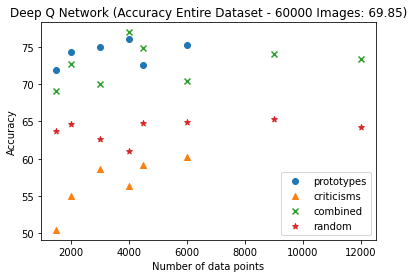

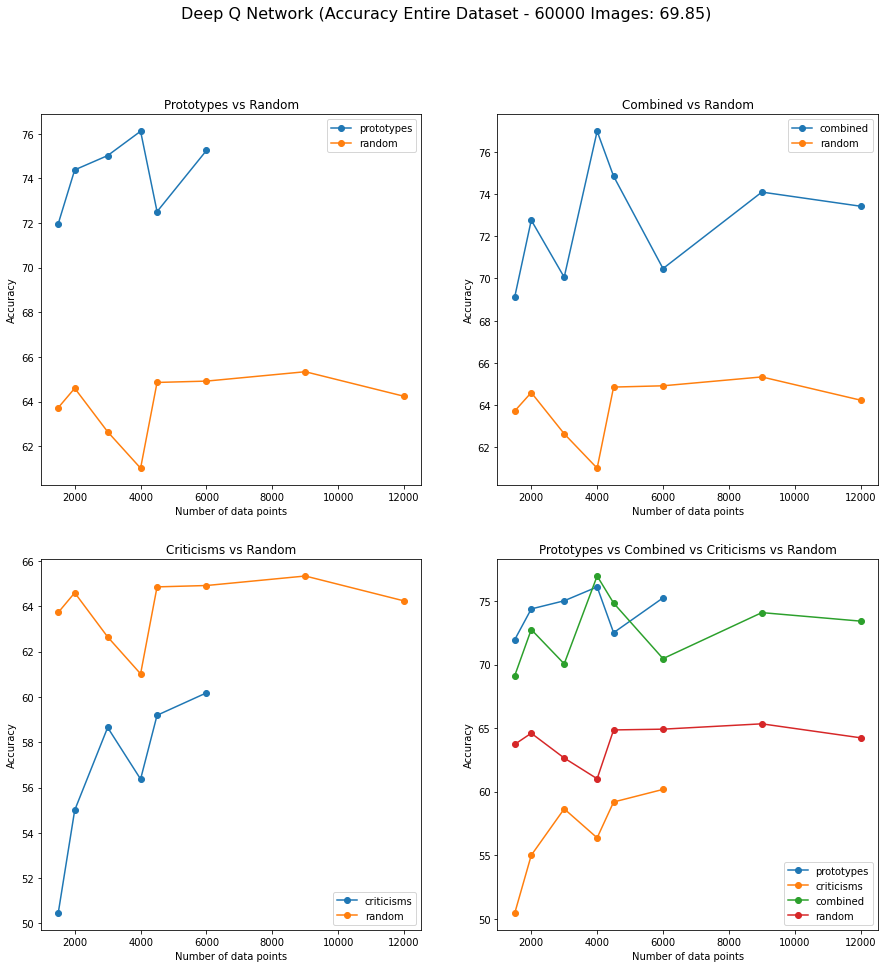

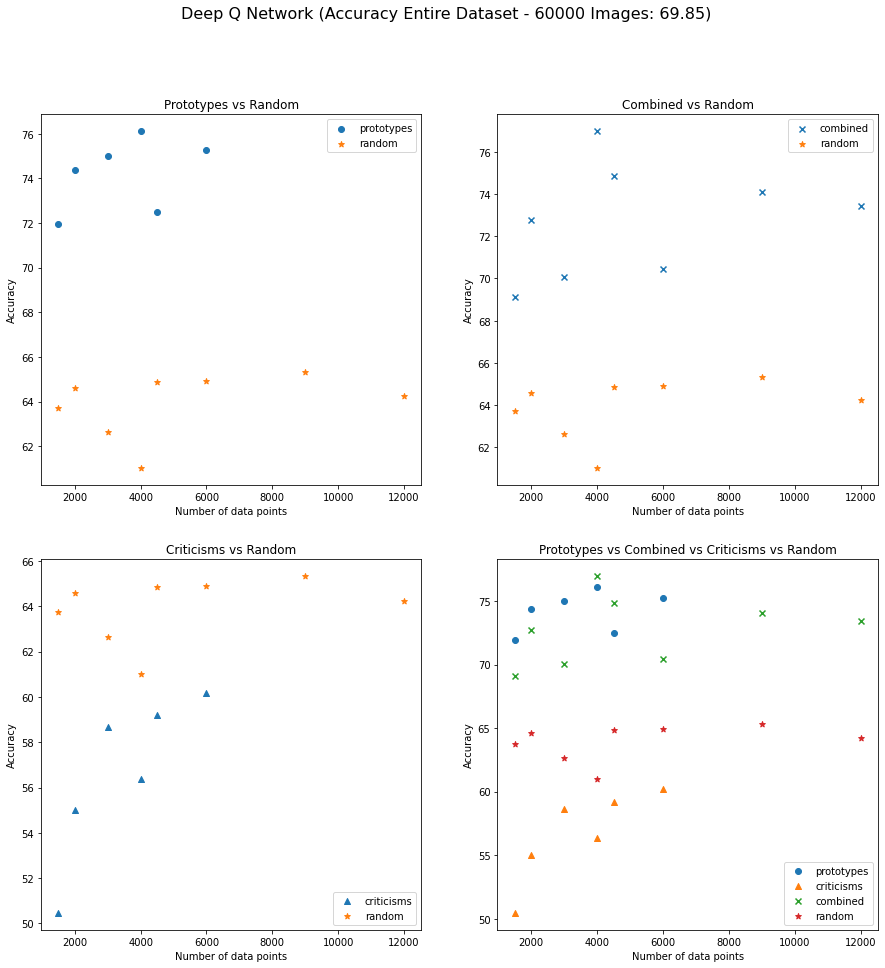

In [28]:
import matplotlib.pyplot as plt
import numpy as np


m = [1500, 2000, 3000, 4000, 4500, 6000, 9000, 12000]
accprotos = [71.97, 74.38, 75.02, 76.11, 72.51, 75.25, np.NaN, np.NaN]
acccritics = [50.46, 55.00, 58.65, 56.37, 59.19, 60.18, np.NaN, np.NaN]
acccombined = [69.14, 72.76, 70.06, 76.97, 74.84, 70.47, 74.09, 73.42]
accrandom = [63.73, 64.60, 62.65, 61.02, 64.86, 64.92, 65.34, 64.24]

# plt.plot(m, accprotos, marker='o', label='prototypes')
# plt.plot(m, acccritics, marker='o', label='criticisms')
# plt.plot(m, acccombined, marker='o', label='combined')
# plt.plot(m, accrandom, marker='o', label='random')
# # plt.plot(m, error)
# plt.legend()
# plt.title('Deep Q Network (Accuracy Entire Dataset - 60000 Images: 69.85)')
# plt.ylabel('Accuracy')
# plt.xlabel('Number of data points')
# plt.show()


plt.scatter(m, accprotos, marker='o', label='prototypes')
plt.scatter(m, acccritics, marker='^', label='criticisms')
plt.scatter(m, acccombined, marker='x', label='combined')
plt.scatter(m, accrandom, marker='*', label='random')
# plt.scatter(m, 69.85, marker='o', label='total')
plt.legend()
plt.title('Deep Q Network (Accuracy Entire Dataset - 60000 Images: 69.85)')
plt.ylabel('Accuracy')
plt.xlabel('Number of data points')
plt.savefig('result_scatter_plot.jpg')
plt.show()


fig, ax = plt.subplots(2, 2, figsize=(15,15))

ax[0, 0].plot(m, accprotos, marker='o', label='prototypes')
ax[0, 0].plot(m, accrandom, marker='o', label='random')

ax[1, 0].plot(m, acccritics, marker='o', label='criticisms')
ax[1, 0].plot(m, accrandom, marker='o', label='random')

ax[0, 1].plot(m, acccombined, marker='o', label='combined')
ax[0, 1].plot(m, accrandom, marker='o', label='random')

ax[1, 1].plot(m, accprotos, marker='o', label='prototypes')
ax[1, 1].plot(m, acccritics, marker='o', label='criticisms')
ax[1, 1].plot(m, acccombined, marker='o', label='combined')
ax[1, 1].plot(m, accrandom, marker='o', label='random')

ax[0, 0].legend(loc="upper right")
ax[0, 1].legend(loc="upper right")
ax[1, 0].legend(loc="lower right")
ax[1, 1].legend(loc="lower right")

ax[0, 0].set_title('Prototypes vs Random')
ax[0, 1].set_title('Combined vs Random')
ax[1, 0].set_title('Criticisms vs Random')
ax[1, 1].set_title('Prototypes vs Combined vs Criticisms vs Random')

ax[0, 0].set_xlabel('Number of data points')
ax[0, 1].set_xlabel('Number of data points')
ax[1, 0].set_xlabel('Number of data points')
ax[1, 1].set_xlabel('Number of data points')

ax[0, 0].set_ylabel('Accuracy')
ax[0, 1].set_ylabel('Accuracy')
ax[1, 0].set_ylabel('Accuracy')
ax[1, 1].set_ylabel('Accuracy')

fig.suptitle('Deep Q Network (Accuracy Entire Dataset - 60000 Images: 69.85)', fontsize=16)
fig.savefig('result_line_plot.jpg')
fig.show()

fig, ax = plt.subplots(2, 2, figsize=(15,15))

ax[0, 0].scatter(m, accprotos, marker='o', label='prototypes')
ax[0, 0].scatter(m, accrandom, marker='*', label='random')

ax[1, 0].scatter(m, acccritics, marker='^', label='criticisms')
ax[1, 0].scatter(m, accrandom, marker='*', label='random')

ax[0, 1].scatter(m, acccombined, marker='x', label='combined')
ax[0, 1].scatter(m, accrandom, marker='*', label='random')

ax[1, 1].scatter(m, accprotos, marker='o', label='prototypes')
ax[1, 1].scatter(m, acccritics, marker='^', label='criticisms')
ax[1, 1].scatter(m, acccombined, marker='x', label='combined')
ax[1, 1].scatter(m, accrandom, marker='*', label='random')

ax[0, 0].legend(loc="upper right")
ax[0, 1].legend(loc="upper right")
ax[1, 0].legend(loc="lower right")
ax[1, 1].legend(loc="lower right")

ax[0, 0].set_title('Prototypes vs Random')
ax[0, 1].set_title('Combined vs Random')
ax[1, 0].set_title('Criticisms vs Random')
ax[1, 1].set_title('Prototypes vs Combined vs Criticisms vs Random')

ax[0, 0].set_xlabel('Number of data points')
ax[0, 1].set_xlabel('Number of data points')
ax[1, 0].set_xlabel('Number of data points')
ax[1, 1].set_xlabel('Number of data points')

ax[0, 0].set_ylabel('Accuracy')
ax[0, 1].set_ylabel('Accuracy')
ax[1, 0].set_ylabel('Accuracy')
ax[1, 1].set_ylabel('Accuracy')

fig.suptitle('Deep Q Network (Accuracy Entire Dataset - 60000 Images: 69.85)', fontsize=16)
fig.savefig('result_scatter_all_plot.jpg')
fig.show()

In [9]:
import random

testm = 'combined/combined_3000.npy'
selected = np.load(testm)
#     print(selected)

data_indices = random.sample(range(0, 6000), 1500)
print(len(x[selected[data_indices], :]), len(y[selected[data_indices]]))

env = DummyVecEnv([lambda: USPSGym(width=64, height=64, channels=1, dataset=(x[selected[data_indices], :], y[selected[data_indices]]))])

# Grab the observation shape for generating evaluation frames.
width, height = env.observation_space.shape[0], env.observation_space.shape[1]

test_model = DQN(CnnPolicy, env, verbose=1)

test_model.learn(total_timesteps=len(x) * 1)

test_model.save('./models/without_norm_{}_{}.zip'.format('protos_1500', 1))

accuracy = eval(test_model, testx, testy)

error = 100 - accuracy
print("=============== m={} error={} ===============".format(1500, error))


data_indices = random.sample(range(0, 6000), 2000)
print(len(x[selected[data_indices], :]), len(y[selected[data_indices]]))

env = DummyVecEnv([lambda: USPSGym(width=64, height=64, channels=1, dataset=(x[selected[data_indices], :], y[selected[data_indices]]))])

# Grab the observation shape for generating evaluation frames.
width, height = env.observation_space.shape[0], env.observation_space.shape[1]

test_model = DQN(CnnPolicy, env, verbose=1)

test_model.learn(total_timesteps=len(x) * 1)

test_model.save('./models/without_norm_{}_{}.zip'.format('protos_2000', 1))

accuracy = eval(test_model, testx, testy)

error = 100 - accuracy
print("=============== m={} error={} ===============".format(2000, error))


data_indices = random.sample(range(0, 6000), 4500)
print(len(x[selected[data_indices], :]), len(y[selected[data_indices]]))

env = DummyVecEnv([lambda: USPSGym(width=64, height=64, channels=1, dataset=(x[selected[data_indices], :], y[selected[data_indices]]))])

# Grab the observation shape for generating evaluation frames.
width, height = env.observation_space.shape[0], env.observation_space.shape[1]

test_model = DQN(CnnPolicy, env, verbose=1)

test_model.learn(total_timesteps=len(x) * 1)

test_model.save('./models/without_norm_{}_{}.zip'.format('protos_4500', 1))

accuracy = eval(test_model, testx, testy)

error = 100 - accuracy
print("=============== m={} error={} ===============".format(4500, error))

NameError: name 'x' is not defined

In [8]:
import random

testm = 'critics/crits_4500.npy'
selected = np.load(testm)
#     print(selected)

data_indices = random.sample(range(0, 4500), 4000)
print(len(x[selected[data_indices], :]), len(y[selected[data_indices]]))

env = DummyVecEnv([lambda: USPSGym(width=64, height=64, channels=1, dataset=(x[selected[data_indices], :], y[selected[data_indices]]))])

# Grab the observation shape for generating evaluation frames.
width, height = env.observation_space.shape[0], env.observation_space.shape[1]

test_model = DQN(CnnPolicy, env, verbose=1)

test_model.learn(total_timesteps=len(x) * 1)

test_model.save('./models/without_norm_{}_{}.zip'.format('critics_4000', 1))

accuracy = eval(test_model, testx, testy)

error = 100 - accuracy
print("=============== m={} error={} ===============".format(4000, error))

4000 4000
Using cpu device
Wrapping the env in a VecTransposeImage.
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 11744    |
|    time_elapsed     | 1        |
|    total timesteps  | 16000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.314    |
|    n_updates        | 2500     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 12301    |
|    time_elapsed     | 2        |
|    total timesteps  | 32000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         

  0%|          | 0/10000 [00:00<?, ?it/s]

Accuracy: 56.37%
=============== m=4000 error=43.63040490538111 ===============


In [9]:
import random

testm = 'combined/combined_4500.npy'
selected = np.load(testm)
#     print(selected)

data_indices = random.sample(range(0, 4500), 4000)
print(len(x[selected[data_indices], :]), len(y[selected[data_indices]]))

env = DummyVecEnv([lambda: USPSGym(width=64, height=64, channels=1, dataset=(x[selected[data_indices], :], y[selected[data_indices]]))])

# Grab the observation shape for generating evaluation frames.
width, height = env.observation_space.shape[0], env.observation_space.shape[1]

test_model = DQN(CnnPolicy, env, verbose=1)

test_model.learn(total_timesteps=len(x) * 1)

test_model.save('./models/without_norm_{}_{}.zip'.format('combined_4000', 1))

accuracy = eval(test_model, testx, testy)

error = 100 - accuracy
print("=============== m={} error={} ===============".format(4000, error))

4000 4000
Using cpu device
Wrapping the env in a VecTransposeImage.
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 12552    |
|    time_elapsed     | 1        |
|    total timesteps  | 16000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.165    |
|    n_updates        | 2500     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 12735    |
|    time_elapsed     | 2        |
|    total timesteps  | 32000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         

  0%|          | 0/10000 [00:00<?, ?it/s]

Accuracy: 76.97%
=============== m=4000 error=23.03157894736843 ===============
